<h2 dir=rtl align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
تعاریف اولیه یک سری واژگان
</font>

<div dir=rtl align=right style="line-height:200%;font-family:vazir;margin-top:20px;color:#fa7e61">
<h3>
    تابع فعال ساز یا activation function
</h3>
</div>

<div dir=rtl align=right style="line-height:200%;font-family:vazir;font-size:14px;margin-top:20px">
    تعریف به زبان ساده اینکه تابعی است که ورودی هارو به خروجی مشخص واسه ما تبدیل میکنه و بهتره ازش استفاده کنیم تا شبکه عصبی بهتری داشته باشیم
</div>

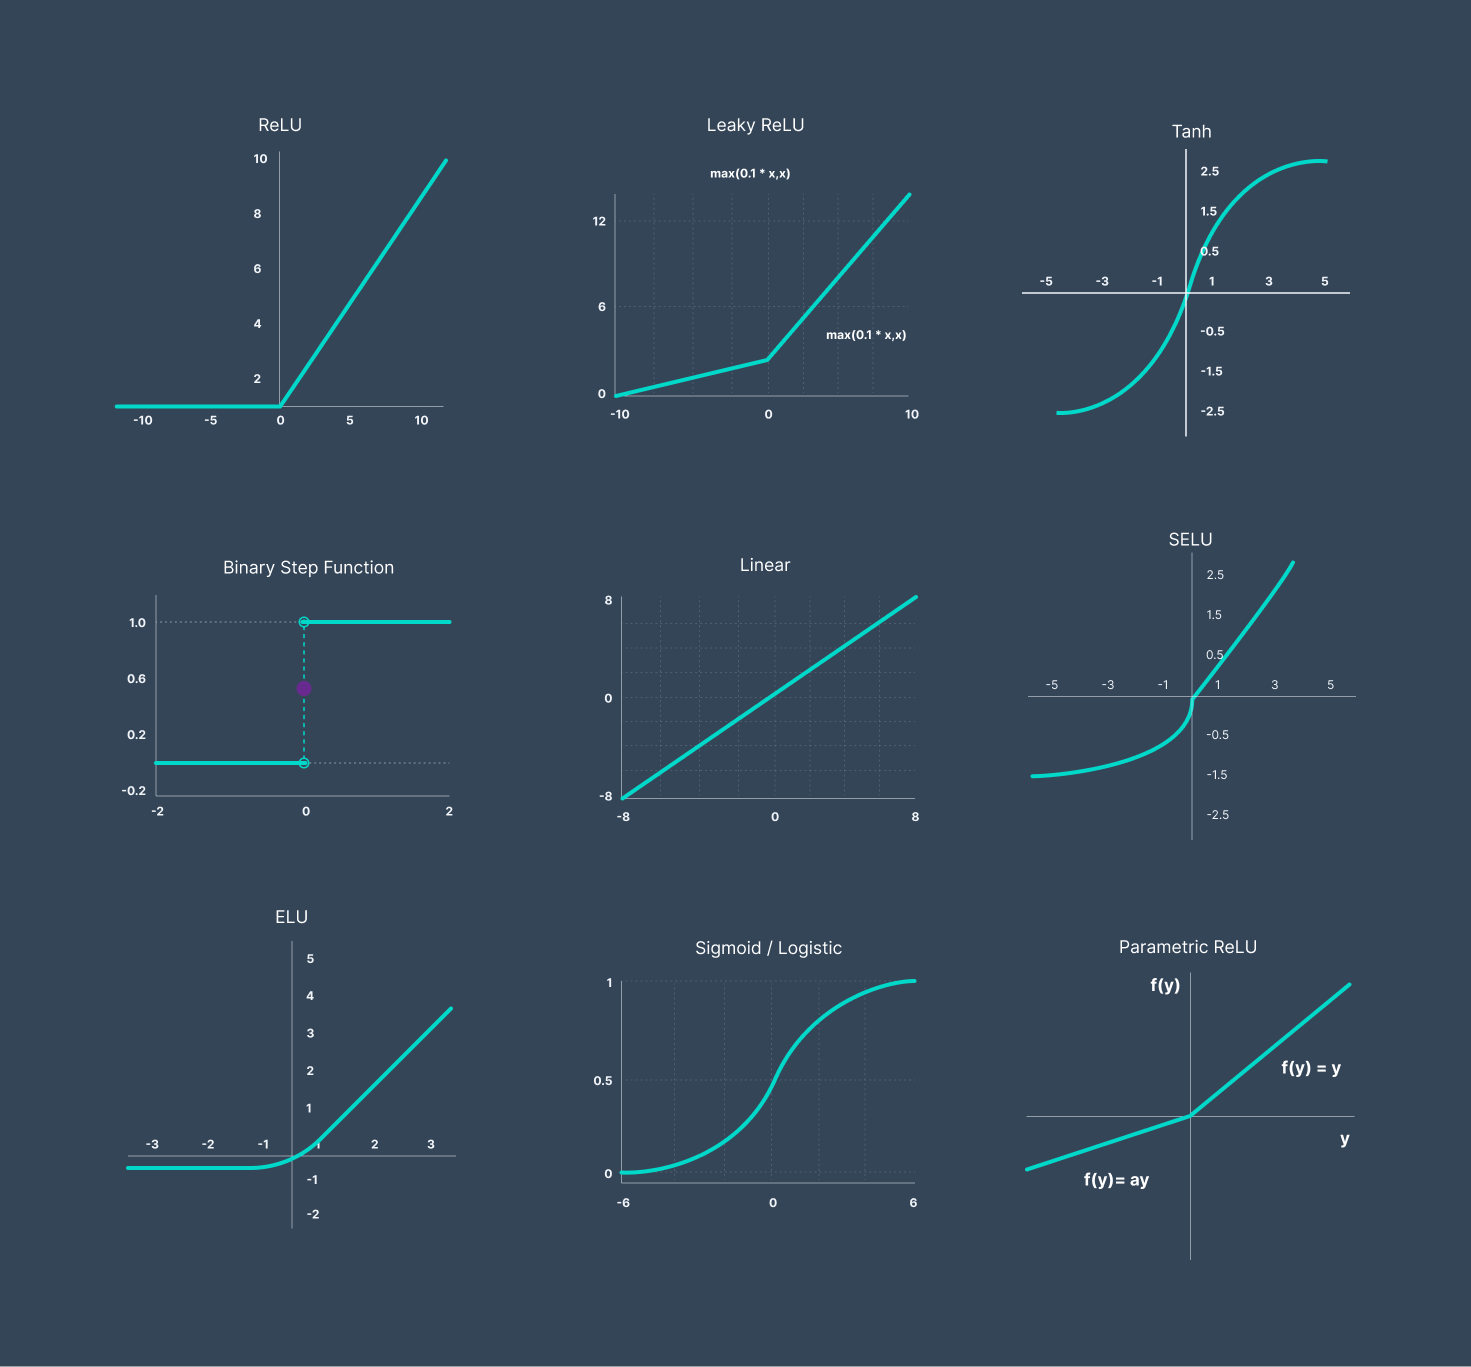

<div dir=rtl align=right style="line-height:200%;font-family:vazir;margin-top:20px;color:#fa7e61">
   <h3>
    optimizer 
   </h3>
</div>

<div dir=rtl align=right style="line-height:200%;font-family:vazir;font-size:14px;margin-top:20px">
   اپدیت وزن ها در شبکه عصبی به عهده اپتیمایزر است واینکه چطوری وزن هارو اپدیت کنیم مهم است 
</div>

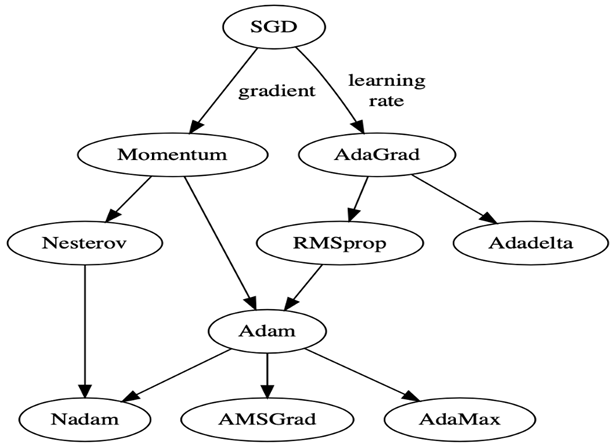

<div dir=rtl align=right style="line-height:200%;font-family:vazir;margin-top:20px;color:#fa7e61">
   <h3>
    Loss 
   </h3>
</div>

<div dir=rtl align=right style="line-height:200%;font-family:vazir;font-size:14px;margin-top:20px">
  تابع ای است که برای ارزیابی کیفیت پیشبینی مدل ازش استفاده میکنیم که اختلاف بین خروجی مدل و مقدار واقعی را محاسبه میکند
</div>

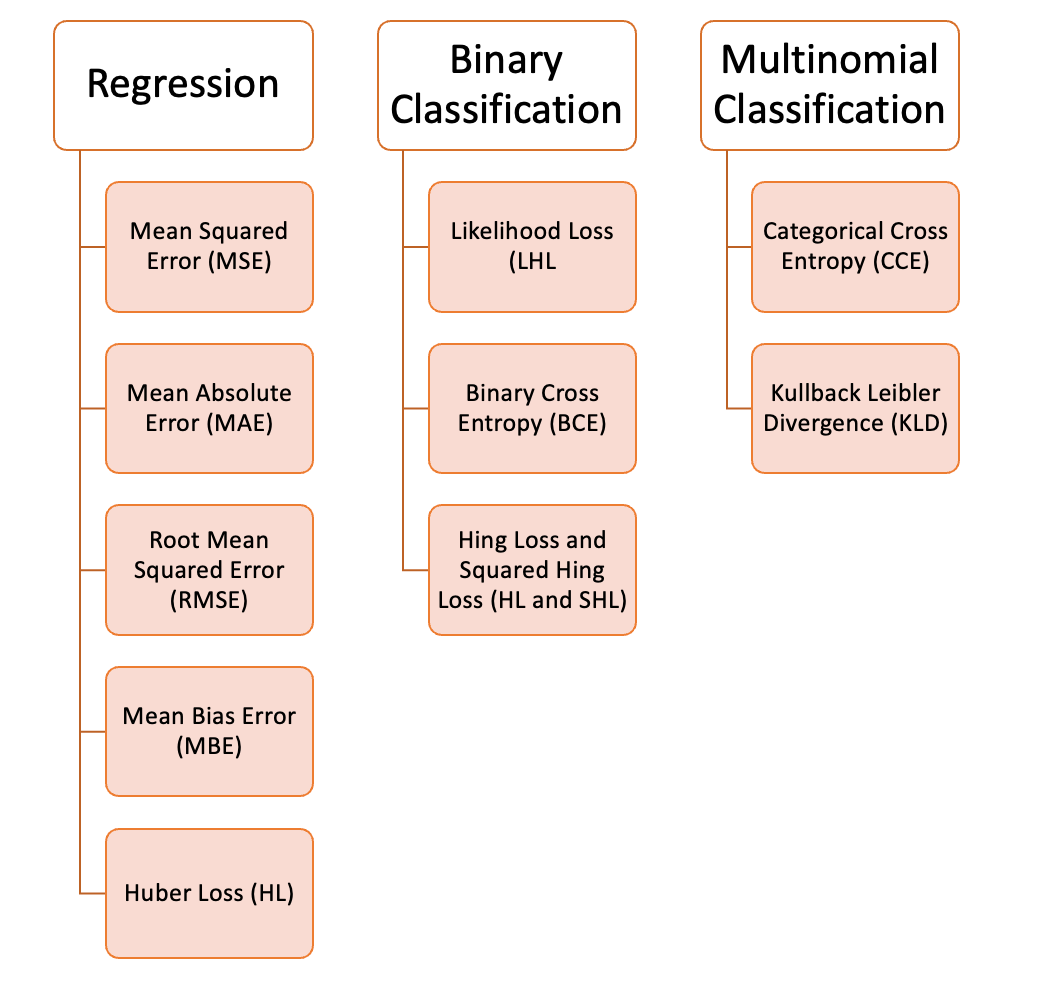

<h2 dir=rtl align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
وارد کردن کتابخونه های لازم برای کار با پایتورچ
</font>
</h2>
<div dir=rtl align=right style="line-height:200%;font-family:vazir;font-size:18px;margin-top:20px">
    با زدن روی این <a href="https://pytorch.org/get-started/locally/">لینک</a> به صفحه نصب پایتورچ خواهید رفت
</div>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

<h2 dir=rtl align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
ساخت مدل
</font>
</h2>

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1)

        self.dropout = nn.Dropout(.3)
        
        self.fc1 = nn.Linear(128 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [5]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx%10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tloss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), loss.item()
            ))

In [6]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    print('\n Test set avarage loss: {:.4f}, accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)
    ))

In [7]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(42)
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1303,), (0.3081,))
])

dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64, num_workers=1, pin_memory=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000, num_workers=1, pin_memory=True, shuffle=True)

model = Model().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(1, 10):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()
    
# torch.save(model.state_dict(), 'mnist_cnn.pt')

Train Epoch: 1 [0/60000 (0%)]	loss: 2.315390
Train Epoch: 1 [640/60000 (1%)]	loss: 1.462126
Train Epoch: 1 [1280/60000 (2%)]	loss: 0.707120
Train Epoch: 1 [1920/60000 (3%)]	loss: 0.544386
Train Epoch: 1 [2560/60000 (4%)]	loss: 0.193991
Train Epoch: 1 [3200/60000 (5%)]	loss: 0.292688
Train Epoch: 1 [3840/60000 (6%)]	loss: 0.348851
Train Epoch: 1 [4480/60000 (7%)]	loss: 0.241209
Train Epoch: 1 [5120/60000 (9%)]	loss: 0.363553
Train Epoch: 1 [5760/60000 (10%)]	loss: 0.156105
Train Epoch: 1 [6400/60000 (11%)]	loss: 0.252096
Train Epoch: 1 [7040/60000 (12%)]	loss: 0.240319
Train Epoch: 1 [7680/60000 (13%)]	loss: 0.067133
Train Epoch: 1 [8320/60000 (14%)]	loss: 0.190236
Train Epoch: 1 [8960/60000 (15%)]	loss: 0.143737
Train Epoch: 1 [9600/60000 (16%)]	loss: 0.113577
Train Epoch: 1 [10240/60000 (17%)]	loss: 0.108904
Train Epoch: 1 [10880/60000 (18%)]	loss: 0.163980
Train Epoch: 1 [11520/60000 (19%)]	loss: 0.439648
Train Epoch: 1 [12160/60000 (20%)]	loss: 0.269311
Train Epoch: 1 [12800/60000 (

In [8]:
import torchvision.transforms as transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1303,), (0.3081,))
])

In [9]:
model = Model()
model_state = torch.load("./mnist_cnn.pt")
model.load_state_dict(model_state)
model.eval()

Model(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=18432, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [10]:
test_image_path = "./test_5.png"
test_image = Image.open(test_image_path).convert("L")
test_data = transform(test_image)

with torch.no_grad():
    output = model(test_data.unsqueeze(0))

In [11]:
output

tensor([[-2.6173e+01, -2.5706e+01, -3.0013e+01, -1.4787e+01, -2.2579e+01,
         -8.3446e-07, -1.5964e+01, -2.3365e+01, -2.1582e+01, -1.4921e+01]])

In [12]:
output.argmax(dim=1, keepdim=True)

tensor([[5]])

<div dir="rtl">
    <h2>برای دانلود این پروژه میتونین QR کد زیر را اسکن کنید </h2>
</div>

<figure>
  <img src="qr.svg" alt="Your SVG Image" width="100"/>
</figure>